In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow_datasets as tfds
(raw_train, raw_validation, raw_test), metadata = tfds.load('oxford_flowers102', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteAIM1MA/oxford_flowers102-train.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteAIM1MA/oxford_flowers102-test.tfrecord


  0%|          | 0/6149 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteAIM1MA/oxford_flowers102-validation.tfrecord


  0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [3]:
 print(raw_train)
 print(raw_validation)
 print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


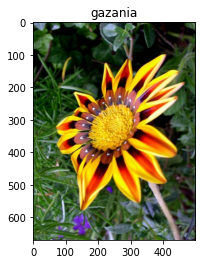

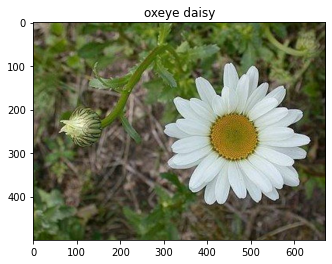

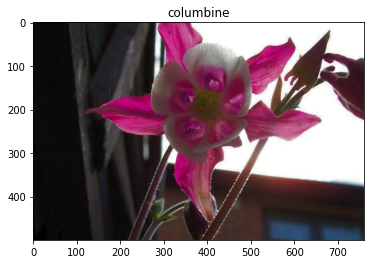

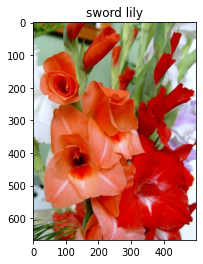

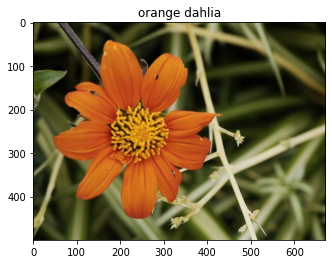

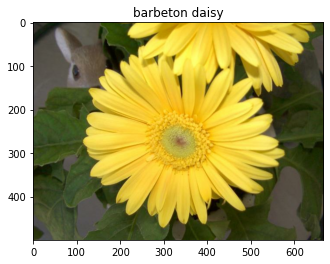

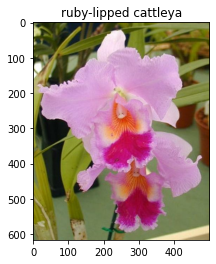

In [4]:
# Showing images from dataset
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(10):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [5]:
#Resize the images to a fixed input size, and rescale the input channels to a range of[-1,1]
IMG_SIZE = 160
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5)- 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [6]:
#Apply the function to each item in the dataset using the map method:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [7]:
# Shuffle and batch the data
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [8]:
# Inspecting a batch of data
for image_batch, label_batch in train_batches.take(1):
  pass
image_batch.shape

TensorShape([64, 160, 160, 3])

In [9]:
# Model set up from a pre-trained convnet
IMG_SHAPE = (IMG_SIZE , IMG_SIZE, 3)
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

74850304/74836368 [==============================] - 2s 0us/step


In [10]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1920)


In [11]:
base_model.trainable = False

In [12]:
# Setting up Model
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.20),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(150, activation='relu'),
                             tf.keras.layers.Dropout(0.20),
                             tf.keras.layers.Dense(102, activation='softmax'),
])

In [13]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 5, 5, 1920)        18321984  
_________________________________________________________________
dense (Dense)                (None, 5, 5, 256)         491776    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               960150    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               1

In [15]:
# Train Model
initial_epochs = 10
history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Epoch 1/10
13/13 [==============================] - 18s 476ms/step - loss: 4.8200 - accuracy: 0.0196 - val_loss: 4.5158 - val_accuracy: 0.0294
Epoch 2/10
13/13 [==============================] - 4s 136ms/step - loss: 4.3385 - accuracy: 0.0588 - val_loss: 4.3858 - val_accuracy: 0.0392
Epoch 3/10
13/13 [==============================] - 4s 136ms/step - loss: 4.0022 - accuracy: 0.1238 - val_loss: 4.1820 - val_accuracy: 0.1078
Epoch 4/10
13/13 [==============================] - 4s 136ms/step - loss: 3.5908 - accuracy: 0.1985 - val_loss: 3.9617 - val_accuracy: 0.1373
Epoch 5/10
13/13 [==============================] - 4s 136ms/step - loss: 3.1908 - accuracy: 0.2966 - val_loss: 3.7686 - val_accuracy: 0.1961
Epoch 6/10
13/13 [==============================] - 4s 140ms/step - loss: 2.7555 - accuracy: 0.4044 - val_loss: 3.5199 - val_accuracy: 0.2353
Epoch 7/10
13/13 [==============================] - 4s 136ms/step - loss: 2.3512 - accuracy: 0.5037 - val_loss: 3.2832 - val_accuracy: 0.2745
Epoch

In [16]:
loss, accuracy = model.evaluate(train_batches)
print('\nTest accuracy before tuning:', accuracy)

13/13 [==============================] - 3s 100ms/step - loss: 0.7313 - accuracy: 0.9424

Test accuracy before tuning: 0.9424019455909729


In [17]:
base_model.trainable = True

In [18]:
# unfreeze thebase_modeland set the bottom layers to be un-trainable
print("Number of layers in the base model:",len(base_model.layers))
#Starting Fine tune
fine_tune_at = 100
# Freeze all the layers befor fine tune
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 707


In [19]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 5, 5, 1920)        18321984  
_________________________________________________________________
dense (Dense)                (None, 5, 5, 256)         491776    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               960150    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               1

In [21]:
# rained to convergence earlier, this step will improve your accuracy by a few percentage points
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_batches, epochs = total_epochs, initial_epoch = history.epoch[-1], validation_data=validation_batches)

Epoch 10/20
13/13 [==============================] - 37s 587ms/step - loss: 2.7792 - accuracy: 0.3652 - val_loss: 2.9556 - val_accuracy: 0.2941
Epoch 11/20
13/13 [==============================] - 6s 291ms/step - loss: 0.6161 - accuracy: 0.9130 - val_loss: 2.5166 - val_accuracy: 0.3627
Epoch 12/20
13/13 [==============================] - 6s 288ms/step - loss: 0.2144 - accuracy: 0.9804 - val_loss: 2.3003 - val_accuracy: 0.4216
Epoch 13/20
13/13 [==============================] - 6s 291ms/step - loss: 0.1025 - accuracy: 0.9914 - val_loss: 2.1616 - val_accuracy: 0.4706
Epoch 14/20
13/13 [==============================] - 6s 290ms/step - loss: 0.0634 - accuracy: 0.9951 - val_loss: 1.9433 - val_accuracy: 0.5196
Epoch 15/20
13/13 [==============================] - 6s 288ms/step - loss: 0.0383 - accuracy: 0.9988 - val_loss: 1.8131 - val_accuracy: 0.5294
Epoch 16/20
13/13 [==============================] - 6s 288ms/step - loss: 0.0256 - accuracy: 0.9988 - val_loss: 1.7127 - val_accuracy: 0.549

In [22]:
loss, accuracy = model.evaluate(train_batches)
print('\nTest accuracy after tuning :', accuracy)

13/13 [==============================] - 3s 100ms/step - loss: 0.0021 - accuracy: 1.0000

Test accuracy after tuning : 1.0
